# Get hourly Google Trends Data for (Time Series) Analysis via Python API

Google Trends is a service which provides meaningful insights on relative search requests on Google. The data can be accessed via the webside https://trends.google.com or Python/R API. In this tutorial I ll show you how to process the data via Python API to get historical and hourly long term Google Trends data.

Google will return relative values between 0 and 100 for your query of an specific keyword. Whereas 0 means lowest search volumne and 100 the highest. A challange I experienced was that that the API returns only about 200 data points for your specified time period. That means if you querie data for one year, you will get about 200 data points, resulting in one data point every 365/~200 days which is scaled from 0 to 100. If you want hourly data, you need to query timeframes, which have about 200 data points and combine them - for example one week = 7*24 = 168 data points. But since your data will be scaled from 0 to 100 for each week of your query, your overall scaling will be wrong. That means, you can not get hourly and correctly scaled trends data for longer time periods without further processing. To get the correct scaling you need to overlap the weeks and calculate a ratio with which you will obtain the proper scaling.

In [15]:
import datetime
from pytrends.request import TrendReq # pip install pytrends - Written for both Python 2.7+ and Python 3.3+
import  pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [19]:
"""Specify start and end date as well es the requiered keyword for your query"""
start_date = datetime.date(2024, 5, 24)
end_date = datetime.date(2024, 6, 6)
keyword_list = ["tinnitus"] # If you add a second string, minor adjustments in the code have to be made

In [20]:
"""Since we want weekly data for our query, we will create lists which include 
the weekly start and end date in the specified timeframe - 2018.01.01 to 2019.5.01"""

weekly_date_list = []

#Adds the start date as first entry in our weekly_date_list
start_date_temp = start_date
weekly_date_list.append(start_date_temp)

#This will return in list of weekly datetime.date objects - except the end date
while start_date_temp+datetime.timedelta(days=7) <= end_date:
    start_date_temp += datetime.timedelta(days=7)
    weekly_date_list.append(start_date_temp)

#This will add the end date to the weekly_date list. We now have a complete list in the specified timeframe
if start_date_temp+datetime.timedelta(days=7) > end_date:
    weekly_date_list.append(end_date)

In [21]:
weekly_date_list

[datetime.date(2024, 5, 24),
 datetime.date(2024, 5, 31),
 datetime.date(2024, 6, 6)]

In [23]:
"""Now we can start to downloading the data via Google Trends API
therefore we have to specify a key which includes the start date
and the end-date with T00 as string for hourly data request"""

#This List will contain pandas Dataframes of weekly data with the features "date",
#"keyword"(which contains weekly scaling bettwen 0 and 100), "isPartial".
#Up to this point, the scaling is not correct.
interest_list = []

#Here we download the data and print the current status of the process
for i in range(len(weekly_date_list)-1):
    key =str(weekly_date_list[i])+"T00 "+str(weekly_date_list[i+1])+"T00"
    p = TrendReq()
    p.build_payload(kw_list=keyword_list, timeframe=key)
    interest=p.interest_over_time()
    interest_list.append(interest)
    print("GoogleTrends Call {} of {} : Timeframe: {} "\
          .format(i+1, len(weekly_date_list)-1, key )
          )    

GoogleTrends Call 1 of 2 : Timeframe: 2024-05-24T00 2024-05-31T00 
GoogleTrends Call 2 of 2 : Timeframe: 2024-05-31T00 2024-06-06T00 


In [24]:
interest_list

[                     tinnitus  isPartial
 date                                    
 2024-05-24 00:00:00        37      False
 2024-05-24 01:00:00        28      False
 2024-05-24 02:00:00        34      False
 2024-05-24 03:00:00        26      False
 2024-05-24 04:00:00        19      False
 ...                       ...        ...
 2024-05-30 20:00:00        33      False
 2024-05-30 21:00:00        33      False
 2024-05-30 22:00:00        31      False
 2024-05-30 23:00:00        31      False
 2024-05-31 00:00:00        30      False
 
 [169 rows x 2 columns],
                      tinnitus  isPartial
 date                                    
 2024-05-31 00:00:00        82      False
 2024-05-31 01:00:00        78      False
 2024-05-31 02:00:00        79      False
 2024-05-31 03:00:00        79      False
 2024-05-31 04:00:00        62      False
 ...                       ...        ...
 2024-06-05 20:00:00        86      False
 2024-06-05 21:00:00        90      False
 2024-0

In [25]:
"""Now we have to rescale our weekly data. We can do this
by overlapping the weekly timeframes by one data point."""

#We define a ratio list, which includes the correction parameters =
#(scaling last hour of week i / scaling first hour of week i+1)
ratio_list = []

#here we apply the correction parameter to all dfs in the interest list except interest_list[0]
for i in range(len(interest_list)-1):
    #Calculation of the ratio
    ratio = float(interest_list[i][keyword_list[0]].iloc[-1])/float(interest_list[i+1][keyword_list[0]].iloc[0]) 
    ratio_list.append(ratio)
    print("{} of {}: Ratio = {}, Scale 1st hour of week {} = {}, scale last hour of week {} = {}"\
          .format(i+1, len(interest_list)-1, ratio_list[i],
                  i+1, float(interest_list[i+1][keyword_list[0]].iloc[0]),
                  i ,float(interest_list[i][keyword_list[0]].iloc[-1]),
                  )
          )
    #Multiply the ratio with the scales of week i+1
    #Therefore we add the column "Scale" and multiply times the value in ratio_list[i]
    #The make the calculations work for round i+1, we overwrite the values column of the df[keyword] with df["Scale"] in the interest list
    interest_list[0]["Scale_{}".format(keyword_list[0])] = interest_list[0][keyword_list[0]]
    interest_list[i+1]["Scale_{}".format(keyword_list[0])] = interest_list[i+1][keyword_list[0]].apply(lambda x:x*ratio_list[i])
    interest_list[i+1][keyword_list[0]] = interest_list[i+1]["Scale_{}".format(keyword_list[0])]

1 of 1: Ratio = 0.36585365853658536, Scale 1st hour of week 1 = 82.0, scale last hour of week 0 = 30.0


In [26]:
"""We now combine the dataframes in the interest list to a Pandas Dataframe.
The data has the correct scaling now. But not yet in the range of 0 and 100."""
df = pd.concat(interest_list)
df.drop(labels = keyword_list[0] , axis = 1, inplace = True)
df.drop(labels = "isPartial", axis = 1, inplace = True)
df.head(5)

,Scale_tinnitus
date,
2024-05-24 00:00:00,37.0
2024-05-24 01:00:00,28.0
2024-05-24 02:00:00,34.0
2024-05-24 03:00:00,26.0
2024-05-24 04:00:00,19.0


In [27]:
"""As last step we scale the data back like google to a range between 0 and 100."""
max_interest = np.max(df["Scale_{}".format(keyword_list[0])])
df["Scale_{}".format(keyword_list[0])]=df["Scale_{}".format(keyword_list[0])]/max_interest*100

In [28]:
df

,Scale_tinnitus
date,
2024-05-24 00:00:00,37.000000
2024-05-24 01:00:00,28.000000
2024-05-24 02:00:00,34.000000
2024-05-24 03:00:00,26.000000
2024-05-24 04:00:00,19.000000
...,...
2024-06-05 20:00:00,31.463415
2024-06-05 21:00:00,32.926829
2024-06-05 22:00:00,33.658537


In [29]:
df.describe()

,Scale_tinnitus
count,314.000000
mean,24.646963
std,7.140625
min,0.000000
25%,21.000000
50%,24.000000
75%,28.170732
max,100.000000


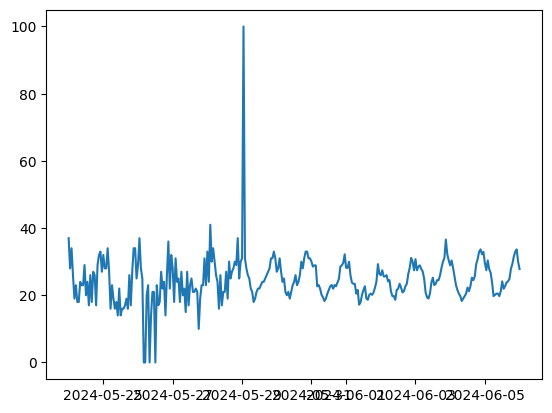

In [30]:
plt.plot(df)

Done. The result shows the hourly google search volumne of the specified timeframe. Maybe there are daily, weekly or yearly patterns? Explore the data. Maybe you can later add the google trends feature as input parameter of an machine learning model for time series prediction.